<a href="https://colab.research.google.com/github/DerNiccoo/TheEarlyBird/blob/main/Aufgabe4/Nico/Aufgabenblatt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
df = pd.read_csv(url, error_bad_lines=False, sep=';', names=['labels','text'])

In [2]:
df = df.drop('labels', axis = 1)
df

,text
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,"'Erfundene Bilder zu Filmen, die als verloren ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Estland sieht den künftigen österreichischen P...
...,...
9240,Bernd Saurer war Bridge-Juniorenweltmeister un...
9241,Sandhere soll in vergangener Woche bei Luftang...
9242,Derzeit Konzeptgruppe in Berlin – Kein Komment...
9243,Landeshauptmann will den vierten Regierungssit...


In [3]:
!pip install -U spacy[cuda100] de
!python -m spacy download de

Requirement already up-to-date: spacy[cuda100] in /usr/local/lib/python3.6/dist-packages (2.3.2)
Requirement already up-to-date: de in /usr/local/lib/python3.6/dist-packages (0.1)
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [4]:
import spacy
gpu = spacy.prefer_gpu()
print('GPU:', gpu)

GPU: True


In [5]:
nlp = spacy.load('de')

list_nouns =[]
df = df[0:200]

for index, row in df.iterrows():
  doc = nlp(row['text'])
  for token in doc:
    if token.pos_ == 'NOUN': 
      list_nouns.append(token.text)

In [6]:
import string

all_letters = string.ascii_letters + 'ÄÖÜäöüß'
list_nouns_ascii = []

for noun in list_nouns:
  contained = True
  
  for char in noun:
    if char not in all_letters:
      contained = False
      break

  if contained:
    list_nouns_ascii.append(noun)

In [7]:
n_categories = 1
all_categories = ['NOUN']

category_lines = {}
category_lines['NOUN'] = list_nouns_ascii

In [8]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

cuda:0


In [9]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [10]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [11]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

In [12]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [13]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
n_letters = len(all_letters) + 1
rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 37s (5000 50%) 3.0360
1m 14s (10000 100%) 2.8679


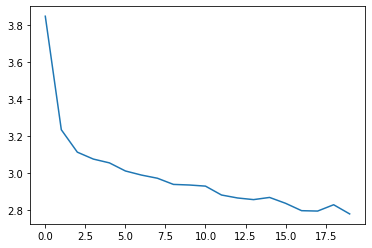

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [17]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A', category='NOUN'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC', category = 'NOUN'):
    for start_letter in start_letters:
        print(sample(start_letter, category))

In [128]:
import numpy as np
import torchvision.transforms as transforms

all_letters_list = [char for char in all_letters]
all_letters_list.append('#')

def sample_pre(start, weighted = False):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor('NOUN')
        input = inputTensor(start)
        hidden = rnn.initHidden()

        output_name = start

        for char in start[:-1]:
          input = inputTensor(char)
          output, hidden = rnn(category_tensor, input[0], hidden)

        input = inputTensor(start[-1])

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)

            if not weighted:
              topv, topi = output.topk(1)
              topi = topi[0][0]
              if topi == n_letters - 1:
                  break
              else:
                  letter = all_letters[topi]
                  output_name += letter
              input = inputTensor(letter)
            else:
              np_array = output.cpu().numpy().ravel()
              norm = np_array / np_array.sum(axis=0, keepdims=1)
              choice = random.choices(all_letters_list, weights=norm, k=1)

              if choice[0] == '#':
                break

              input = inputTensor(choice)
              output_name += choice[0]

        return output_name

def better_random(start):
  return start + ''.join(random.choices(all_letters, k=random.randint(2, 20 - len(start))))

In [129]:
sample_pre("Max")

'Maxten'

In [130]:
word_count = 10

def test_model(word_count):
  for i in range(word_count):
    word = randomChoice(list_nouns_ascii)
    
    prefix = word[: random.randint(2, len(word) - 2)] # hier mal -2, damit mid. 1 char von dem Wort bleibt
    
    max_score = sample_pre(prefix)
    weighted_sum = sample_pre(prefix, True)
    rand_samp = better_random(prefix)
    print('Word: {:30} Prefix: {:30} MaxScore: {:30} WeightedSum: {:30} Random: {:30}'. format(word, prefix, max_score, weighted_sum, rand_samp))

test_model(word_count)

Word: Loch                           Prefix: Lo                             MaxScore: Lonter                         WeightedSum: LowäGÖogUlDCuipVLVDOUD         Random: LoÄMlXvEXw                    
Word: Tasse                          Prefix: Ta                             MaxScore: Tanten                         WeightedSum: TaqSoyUJVVjKWvxmHmßwHx         Random: TanVßfwOaIoajAWp              
Word: Grasser                        Prefix: Gr                             MaxScore: Grter                          WeightedSum: GrFQRJpüdzCTÄKkÄZMvpdY         Random: GrHkvbobfßatVaLüOhoT          
Word: Ideologie                      Prefix: Id                             MaxScore: Iden                           WeightedSum: IdCÜCcoIwCöÄoIHäxßqjzP         Random: IdzWsü                        
Word: Jahre                          Prefix: Jah                            MaxScore: Jahten                         WeightedSum: JahANPcBFQSüUQTÜMZcEPGL        Random: JahmBzFÜ                      
